<a href="https://colab.research.google.com/github/nilakshi104/Classifying-name-with-character-level-RNN/blob/master/French_to_Eng_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from io import open
import torch
import torch.nn as nn
import random
import re
import unicodedata
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
path='/content/drive/My Drive/data/NLP/data/eng-fra.txt'
path1='/content/drive/My Drive/data/NLP/data/sequence to sequence transfer using attention model/'

In [3]:
SOS_token=0
EOS_token=1
class Lang():                       #NO NEED OF NN.MODULE COZ BASIC OPP
  def __init__(self,name):
    #super(Lang,self).__init__()     HERE NO NEED AS BASIC OPERATIONS ARE PERFORMED NOT ONE WITH NN.MODULE
    self.name=name
    self.word2index={'SOS':0,'EOS':1}
    self.index2word={0:'SOS',1:'EOS'}
    self.word2count={}
    self.index=2

  def addWord(self,pair):
    pair1=pair.split(' ')
    for pi in pair1:
      if pi not in self.word2index:
        self.word2index[pi]=self.index
        self.index2word[self.index]=pi
        self.word2count[pi]=1
        self.index+=1
      else:
        self.word2count[pi]+=1



In [4]:
lang=Lang('eng')
lang.addWord('hey come here > hey come')

print(lang.word2index)
print(lang.index2word)
print(lang.word2count)

{'SOS': 0, 'EOS': 1, 'hey': 2, 'come': 3, 'here': 4, '>': 5}
{0: 'SOS', 1: 'EOS', 2: 'hey', 3: 'come', 4: 'here', 5: '>'}
{'hey': 2, 'come': 2, 'here': 1, '>': 1}


In [5]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
  s=unicodeToAscii(s.lower().strip())
  s=re.sub(r"([.!?])",r" \1",s)
  s=re.sub(r"[^a-zA-Z.?!]",r" ",s)
  return s

def readLangs():
  lines=open(path,encoding='utf-8').read().strip().split('\n')
  pairs=[[normalizeString(s)for s in line.split('\t')] for line in lines]
  return pairs
  


In [6]:
readLangs()

[['go .', 'va  !'],
 ['run !', 'cours  !'],
 ['run !', 'courez  !'],
 ['wow !', 'ca alors  !'],
 ['fire !', 'au feu  !'],
 ['help !', 'a l aide  !'],
 ['jump .', 'saute .'],
 ['stop !', 'ca suffit  !'],
 ['stop !', 'stop  !'],
 ['stop !', 'arrete toi  !'],
 ['wait !', 'attends  !'],
 ['wait !', 'attendez  !'],
 ['i see .', 'je comprends .'],
 ['i try .', 'j essaye .'],
 ['i won !', 'j ai gagne  !'],
 ['i won !', 'je l ai emporte  !'],
 ['oh no !', 'oh non  !'],
 ['attack !', 'attaque  !'],
 ['attack !', 'attaquez  !'],
 ['cheers !', 'sante  !'],
 ['cheers !', 'a votre sante  !'],
 ['cheers !', 'merci  !'],
 ['get up .', 'leve toi .'],
 ['got it !', 'j ai pige  !'],
 ['got it !', 'compris  !'],
 ['got it ?', 'pige  ?'],
 ['got it ?', 'compris  ?'],
 ['got it ?', 't as capte  ?'],
 ['hop in .', 'monte .'],
 ['hop in .', 'montez .'],
 ['hug me .', 'serre moi dans tes bras  !'],
 ['hug me .', 'serrez moi dans vos bras  !'],
 ['i fell .', 'je suis tombee .'],
 ['i fell .', 'je suis tombe .'

NOTE:IF CLASS IS DEFINED WE CAN ACSSES VARIABLES IN CLASS BY CLASS_NAME.VARIABLE_NAME 
BUT FOR FUNCTION SAME IS NOT APPLICABLE
COZ THERE IS SELF IN CLASS.IF WE DEFINE OUTPUT AS 'M' INSTED 'SELF.M' WE WONT BE ABLE TO CALL VARIABLE M OUTSIDE THE CLASS USING CLASS_NAME.VARIABLE_NAME 

In [7]:
MAX_LENGTH=10
eng_prefixes=("i am","i m","he is","he s","you are","you re","we are","we re","they are","they re")
def filterPair(pair):
  return len(pair[0].split(' '))<MAX_LENGTH and len(pair[1].split(' '))<MAX_LENGTH and pair[0].startswith(eng_prefixes)
  # initially 0:eng,1:french
def filterPairs(pairs):
  return [pair for pair in pairs if filterPair(pair)]

In [8]:
def PrepareData(lang1,lang2,reverse):
  pairs=readLangs()
  pairs=filterPairs(pairs)
  if reverse:
    pairs=[list(reversed(pair)) for pair in pairs]
    input_lang=Lang(lang2)
    output_lang=Lang(lang1)
  else:
    input_lang=Lang(lang1)
    output_lang=Lang(lang2)
  for pair in pairs:
    input_lang.addWord(pair[0])
    output_lang.addWord(pair[1])
  return input_lang,output_lang,pairs

In [9]:
input_lang,output_lang,pairs=PrepareData('eng','french',reverse=True) #for eng to french use reverse=False coz original data was eng,french separeted by tab

In [10]:
pairs

[['j ai    ans .', 'i m    .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .'],
 ['je suis gras .', 'i m fat .'],
 ['je suis gros .', 'i m fat .'],
 ['je suis en forme .', 'i m fit .'],
 ['je suis touche  !', 'i m hit !'],
 ['je suis touchee  !', 'i m hit !'],
 ['je suis malade .', 'i m ill .'],
 ['je suis triste .', 'i m sad .'],
 ['je suis timide .', 'i m shy .'],
 ['je suis mouille .', 'i m wet .'],
 ['je suis mouillee .', 'i m wet .'],
 ['il est mouille .', 'he s wet .'],
 ['je suis gras .', 'i am fat .'],
 ['je suis revenu .', 'i m back .'],
 ['me revoila .', 'i m back .'],
 ['je suis chauve .', 'i m bald .'],
 ['je suis occupe .', 'i m busy .'],
 ['je suis occupee .', 'i m busy .'],
 ['je suis calme .', 'i m calm .'],
 ['j ai froid .', 'i m cold .'],
 ['j en ai fini .', 'i m done .'],
 ['tout va bien .', 'i m fine .'],
 ['je vais bien .', 'i m fine .'],
 ['ca va .', 'i m fine .'],
 ['je suis libre  !', 'i m free !'],
 ['je suis libre .', 'i m free .'],
 ['je suis dispo

WHAT DOES NN.EMBEDDING LAYER DO?

**initially it get randomly initialized,during training its values gets modified.first_para basically createsrows for total no of word in train+test+val and second para is number of features for embedding vector.Instead of this pretrained n/w like glove2vec can be used.For english text and french text there will be 2 diffn embedding vector so first para will vary for both emb vector i.e in encoder and decoder/attention model**

[ENCODER-DECODER](https://drive.google.com/file/d/1P2Hqk9FKp4cWUnQI5jVtpl8dDrZ78IZZ/view?usp=sharing)

In [11]:
class EncoderRNN(nn.Module):
  def __init__(self,input_size,hidden_size):
    super(EncoderRNN,self).__init__()
    self.hidden_size=hidden_size
    self.embedding=nn.Embedding(input_size,hidden_size)
    self.gru=nn.GRU(hidden_size,hidden_size)

  def forward(self,input,hidden):
    embedded=self.embedding(input).view(1,1,-1)
    output,hidden=self.gru(embedded,hidden)
    return output,hidden
  
  def initHidden(self):
    return torch.zeros(1,1,self.hidden_size)


In [12]:
class DecoderRNN(nn.Module):
  def __init__(self,hidden_size,output_size):
    super(DecoderRNN,self).__init__()
    self.hidden_size=hidden_size
    self.embedding=nn.Embedding(output_size,hidden_size)
    self.gru=nn.GRU(hidden_size,hidden_size)
    self.out=nn.Linear(hidden_size,output_size)

  def forward(self,input,hidden):
    embedded=self.embedding(input).view(1,1,-1)
    output,hidden=self.gru(F.relu(embedded),hidden)
    output=nn.LogSoftmax(dim=1)(self.out(output[0]))        #instead of nn.Softmax,nn.LogSoftmax is used coz in softmax each val<1 so after mul of prob value becomes << 1 
    # whereas same doesnt happen with logsoftmax as each value is negative and mode of that number is >1(in case of logsoftmax num whose mode is less is selected as op due to its negative sign)
    return output,hidden

  def initHidden(self):
    return torch.zeros(1,1,self.hidden_size)


[ATTENTION MODEL](https://drive.google.com/file/d/1P6W6W7jDsR1mmCwvN6Nl4YKRUa-nLCQ0/view?usp=sharing)

In [13]:
class AttnDecoderRNN(nn.Module):
  def __init__(self,hidden_size,output_size,dropout_p=0.1,max_length=MAX_LENGTH):
    super(AttnDecoderRNN, self).__init__()
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.dropout_p=dropout_p
    self.max_length=max_length

    self.embedding=nn.Embedding(output_size,hidden_size)
    self.attn=nn.Linear(hidden_size+hidden_size,max_length)
    self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(self.dropout_p)
    self.gru = nn.GRU(self.hidden_size, self.hidden_size)
    self.out = nn.Linear(self.hidden_size, self.output_size)

  def forward(self,input,hidden,encoder_outputs):
    embedded=self.embedding(input).view(1,1,-1)
    embedded=self.dropout(embedded)
    attn_weights = nn.Softmax(dim=1)(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
    attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))

    output = torch.cat((embedded[0], attn_applied[0]), 1)
    output = self.attn_combine(output).unsqueeze(0)

    output = F.relu(output)
    output, hidden = self.gru(output, hidden)

    output = F.log_softmax(self.out(output[0]), dim=1)
    return output, hidden, attn_weights

  def initHidden(self):
    return torch.zeros(1, 1, self.hidden_size)

In [14]:
def senttoindex(lang,pair):
  pair=[lang.word2index[pair1] for pair1 in pair.split(' ')]
  pair.append(EOS_token)
  return torch.tensor(pair, dtype=torch.long).view(-1, 1)

def tensor_sent(pair):
  input_tensor=senttoindex(input_lang,pair[0])
  target_tensor=senttoindex(output_lang,pair[1])
  return (input_tensor,target_tensor)

In [ ]:
teacher_forcing_ratio=0.5

def train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,max_length=MAX_LENGTH):
  encoder_hidden=encoder.initHidden()
  encoder_optimizer.zero_grad()
  decoder_optimizer.zero_grad()
  input_length=input_tensor.size(0)
  target_length=target_tensor.size(0)
  decoder_input=torch.tensor([[SOS_token]])
  encoder_outputs=torch.zeros(max_length,encoder.hidden_size)
  loss=0
  for i in range(input_length):
    encoder_output,encoder_hidden=encoder(input_tensor[i],encoder_hidden)
    encoder_outputs[i]=encoder_output[0,0]
  decoder_hidden=encoder_hidden

  teacher_force=True if random.random() < teacher_forcing_ratio else False
  if teacher_force:
    for j in range(target_length):
      decoder_output,decoder_hidden,decoder_attention=decoder(decoder_input,decoder_hidden,encoder_outputs)
      decoder_input=target_tensor[j]
      loss+=criterion(decoder_output,target_tensor[j])
      if decoder_input.item()== EOS_token:
        break
  else:
    for j in range(target_length):  #we need to force model to op sentence having length similar to target sentence
      decoder_output,decoder_hidden,decoder_attention=decoder(decoder_input,decoder_hidden,encoder_outputs)
      topv,topi=decoder_output.topk(1)
      decoder_input=topi.squeeze().detach()
      loss+=criterion(decoder_output,target_tensor[j])
      if decoder_input.item()== EOS_token:
        break
  loss.backward()
  encoder_optimizer.step()
  decoder_optimizer.step()

  return loss.item()/(j+1)



In [ ]:
def trainIters(pairs,encoder,decoder,n_iters,print_every=1000,plot_every=100,learning_rate=0.01,max_length=MAX_LENGTH):
  plot_losses=[]
  print_loss_total=0
  plot_loss_total=0
  encoder_optimizer=optim.SGD(encoder.parameters(),lr=learning_rate)
  decoder_optimizer=optim.SGD(decoder.parameters(),lr=learning_rate)
  criterion=nn.NLLLoss()

  train_dataset=[tensor_sent(random.choice(pairs)) for i in range(n_iters)]     #COZ RANDOM SHUFFLE IS MUST
  
  for iter in range(1,n_iters+1):
    pair=train_dataset[iter-1]
    input_tensor=pair[0]
    target_tensor=pair[1]
    loss=train(input_tensor,target_tensor,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion,max_length)

    print_loss_total+=loss
    plot_loss_total+=loss

    if iter % plot_every == 0:
      plot_loss_avg = plot_loss_total / plot_every
      plot_losses.append(plot_loss_avg)
      plot_loss_total = 0

    if iter % print_every == 0:
      print_loss_avg=print_loss_total/print_every
      print_loss_total=0
      print('%d %d%% %.4f'%(iter,iter/n_iters*100,print_loss_avg))
      print('  ')
      with torch.no_grad():
        eval_data=random.choice(pairs)
        print('input:%s'%(eval_data[0]))
        print('target:%s'%(eval_data[1]))
        input_tensor,target_tensor=tensor_sent(eval_data)
        input_length=input_tensor.size(0)
        encoder_hidden=encoder.initHidden()
        encoder_outputs=torch.zeros(max_length,encoder.hidden_size)

        for i in range(input_length):
          encoder_output,encoder_hidden=encoder(input_tensor[i],encoder_hidden)
          encoder_outputs[i]=encoder_output[0,0]
        
        decoder_input = torch.tensor([[SOS_token]])
        decoder_hidden=encoder_hidden
        decoder_words=[]
        decoder_attentions=torch.zeros(max_length,max_length)

        for j in range(max_length):
          decoder_output,decoder_hidden,decoder_attention=decoder(decoder_input,decoder_hidden,encoder_outputs)
          decoder_attentions[j] = decoder_attention.data
          topv,topi=decoder_output.topk(1)
          decoder_input=topi.squeeze().detach()
          if decoder_input.item()==EOS_token:
            break
          else:
            decoder_words.append(output_lang.index2word[topi.item()])
        print('output_word: %s'%" ".join(decoder_words))
        print('___________________________________________________________')

  plt.figure()      
  plt.plot(plot_losses)
  plt.xlabel('iteration')
  plt.ylabel('loss')

  torch.save(encoder.state_dict(),path1+"state_dict_encoder.pth")
  print('saved encoder state dict!')
  torch.save(decoder.state_dict(),path1+"state_dict_decoder.pth")
  print('saved decoder state dict!')


5000 6% 3.1975
  
input:il n est pas la en ce moment .
target:he isn t here now .
output_word: he s not the the .
___________________________________________________________
10000 13% 2.5110
  
input:il est en bonne condition physique .
target:he s in good physical condition .
output_word: he is a good of his .
___________________________________________________________
15000 20% 2.1826
  
input:je suis content de te voir ici .
target:i m glad to see you here .
output_word: i m glad to see you here .
___________________________________________________________
20000 26% 1.8976
  
input:tu es la maitresse .
target:you re the master .
output_word: you re the teacher .
___________________________________________________________
25000 33% 1.6800
  
input:nous ne sommes pas partenaires .
target:we re not partners .
output_word: we re not dressed .
___________________________________________________________
30000 40% 1.5268
  
input:tu n es pas assez rapide .
target:you re not fast enough .
o

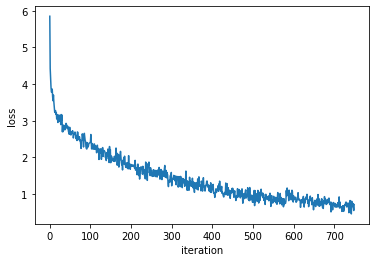

In [ ]:
input_lang,output_lang,pairs=PrepareData('eng','french',reverse=True)
hidden_size = 256
encoder1 = EncoderRNN(input_lang.index, hidden_size)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.index, dropout_p=0.1)

trainIters(pairs,encoder1, attn_decoder1, 75000, print_every=5000)

In [15]:
def evaluate(sentence,encoder,decoder,max_length):
  with torch.no_grad():
    encoder_hidden=encoder.initHidden()
    encoder_input=senttoindex(input_lang,sentence)
    input_length=encoder_input.size()[0]
    attention_weights=torch.zeros(max_length,max_length)
    encoder_outputs=torch.zeros(max_length,encoder.hidden_size)
    output_words=[]
    for ei in range(input_length):
      encoder_output,encoder_hidden=encoder(encoder_input[ei],encoder_hidden)
      encoder_outputs[ei]=encoder_output[0,0]
    decoder_input=torch.tensor([[SOS_token]])
    decoder_hidden=encoder_hidden
    for di in range(max_length):
      decoder_output,decoder_hidden,attention_weight=decoder(decoder_input,decoder_hidden,encoder_outputs)
      attention_weights[di]=attention_weight.data
      topv,topi=decoder_output.topk(1)
      if topi.item()==EOS_token:
        output_words.append('<EOS>')
        break
      else:
        output_words.append(output_lang.index2word[topi.item()])

      decoder_input=topi.squeeze().detach()

    return output_words,attention_weights[:di+1]

In [ ]:
def evaluateRandomly(encoder,decoder,n=10):
  for i in range(n):
    pair = random.choice(pairs)
    print('>', pair[0])
    print('=', pair[1])
    output_words, attentions = evaluate( pair[0],encoder, decoder,MAX_LENGTH)
    output_sentence = ' '.join(output_words)
    print('<', output_sentence)
    print('')


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

> c est un homme de foi .
= he is a man of faith .
< he is a man of . <EOS>

> je suis paye pour faire ca .
= i m being paid to do this .
< i m being paid to do this . <EOS>

> je suis un peu perplexe .
= i m a little confused .
< i m a little confused . <EOS>

> je me tire .
= i m going .
< i m feeling . <EOS>

> il est tres prudent .
= he is very careful .
< he is very careful . <EOS>

> vous etes dans une propriete privee  ici .
= you re trespassing here .
< you re trespassing here . <EOS>

> je suis presque effraye de vous parler .
= i am almost scared to talk with you .
< i m trying about to you . <EOS>

> je suis timide .
= i m shy .
< i m shy . <EOS>

> je suis sure qu il reussira .
= i am sure of his success .
< i am sure that he will . <EOS>

> il a l air en colere .
= he sounds angry .
< he is to angry . <EOS>



In [ ]:
output_words,attention=evaluate("ils arrivent",encoder1, attn_decoder1,MAX_LENGTH)

In [ ]:
k='they are coming'
print('target: %s'%k)
print('output: %s'%' '.join(output_words))

target: they are coming
output: they re talking . <EOS>


VISUALIZING ATTENTION

input = elle a cinq ans de moins que moi .
output = he swims interested in than do . <EOS>


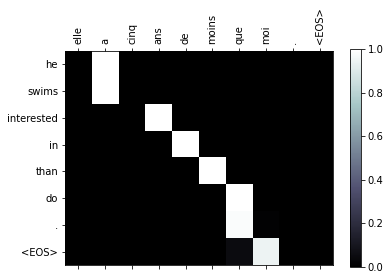

input = elle est trop petit .
output = i am too short . <EOS>


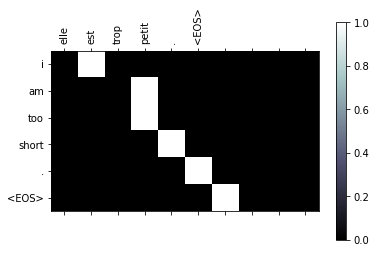

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


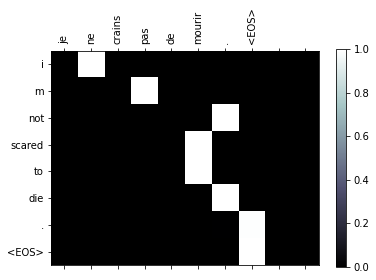

input = c est un jeune directeur plein de talent .
output = he s a talented young . <EOS>


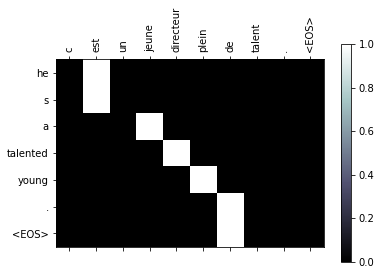

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(input_sentence,
        encoder1, attn_decoder1,MAX_LENGTH)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

Using Saved model

In [16]:
input_lang,output_lang,pairs=PrepareData('eng','french',reverse=True)
hidden_size = 256
encoder_model = EncoderRNN(input_lang.index, hidden_size)
encoder_model.load_state_dict(torch.load('/content/drive/My Drive/data/NLP/data/sequence to sequence transfer using attention model/state_dict_encoder.pth'))
encoder_model.eval()
attn_decoder_model = AttnDecoderRNN(hidden_size, output_lang.index, dropout_p=0.1)
attn_decoder_model.load_state_dict(torch.load('/content/drive/My Drive/data/NLP/data/sequence to sequence transfer using attention model/state_dict_decoder.pth'))
attn_decoder_model.eval()

AttnDecoderRNN(
  (embedding): Embedding(3012, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=3012, bias=True)
)

In [48]:
from nltk.translate.bleu_score import sentence_bleu
def evaluate(sentence,reference,encoder,decoder,max_length):
  reference=reference.split(' ')
  encoder_hidden=encoder.initHidden()
  encoder_input=senttoindex(input_lang,sentence)
  input_length=encoder_input.size()[0]
  attention_weights=torch.zeros(max_length,max_length)
  encoder_outputs=torch.zeros(max_length,encoder.hidden_size)
  output_words=[]
  for ei in range(input_length):
    encoder_output,encoder_hidden=encoder(encoder_input[ei],encoder_hidden)
    encoder_outputs[ei]=encoder_output[0,0]
  decoder_input=torch.tensor([[SOS_token]])
  decoder_hidden=encoder_hidden
  for di in range(max_length):
    decoder_output,decoder_hidden,attention_weight=decoder(decoder_input,decoder_hidden,encoder_outputs)
    attention_weights[di]=attention_weight.data
    topv,topi=decoder_output.topk(1)
    if topi.item()==EOS_token:
      output_words.append('<EOS>')
      break
    else:
      output_words.append(output_lang.index2word[topi.item()])
    decoder_input=topi.squeeze().detach()
  candidate=output_words
  weight_array=np.zeros(len(candidate))+1/len(candidate)
  weight_tuple=tuple(w for w in weight_array)
  print(weight_tuple)
  bleu_score=sentence_bleu(reference, candidate, weights=weight_tuple)

  return output_words,attention_weights[:di+1],bleu_score

In [49]:
sentence='je suis en train de manger .'
candidate='i am eating .'
print('target:{}'.format(candidate))
output,attention_weights,bleu_score=evaluate(sentence,candidate,encoder_model,attn_decoder_model,10)
print('output: '+' '.join(output))
print('bleu score is {}'.format(bleu_score))

target:i am eating .
(0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666)
output: i m eating now . <EOS>
bleu score is 0.8908987181403393


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [50]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['i','am','eating','.']]
candidate = ['i','m','eating','now','.','<EOS>']
score=sentence_bleu(reference, candidate, weights=(0.166667,0.166667,0.166667,0.166667,0.166667,0.166667))
score

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8908985122990515